In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

import random
from pathlib import Path

from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
# import pandas as pd
# pd.options.display.width = 1000

import os, sys
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from vrAnalysis import analysis
from vrAnalysis import helpers
from vrAnalysis import database
from vrAnalysis import tracking
from vrAnalysis import fileManagement as fm
from vrAnalysis import faststats as fs

from vrAnalysis.syd_viewers.placecell_across_session_rel import PlaceFieldLoader, get_cell_viewer, get_summary_viewer

from syd import make_viewer

sessiondb = database.vrDatabase('vrSessions')
mousedb = database.vrDatabase('vrMice')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [8]:
cell_loader = PlaceFieldLoader("CR_Hippocannula6", keep_planes=[1, 2, 3, 4], sesmethod="all", onefile="mpci.roiSignificantFluorescence", summary_only=False)

In [9]:
viewer = get_cell_viewer(cell_loader).deploy(suppress_warnings=True)

No such comm: 2a192384c51648df9135b4c2cee26d9f


No such comm: fba745b8315244e6b5a4158ea88937f2


No such comm: 7dd0d88e9df04a78ae1fc12e2b54418d


No such comm: f09e82036bf348b6b8bdf60a41426d42


No such comm: e06cace3f179422495f19c4789966b0a


No such comm: 63d0a94949c0400098e95d601b287f3b


No such comm: 6bf9c858c69f468cb4ec3290b39be3e4
No such comm: 6bf9c858c69f468cb4ec3290b39be3e4
No such comm: 6bf9c858c69f468cb4ec3290b39be3e4
No such comm: 6bf9c858c69f468cb4ec3290b39be3e4
No such comm: 6bf9c858c69f468cb4ec3290b39be3e4


In [ ]:
loader = PlaceFieldLoader("CR_Hippocannula6", keep_planes=[1, 2, 3, 4], sesmethod="all", onefile="mpci.roiSignificantFluorescence", summary_only=True)

In [3]:
viewer = get_summary_viewer(loader).deploy(controls_position="right",suppress_warnings=True)

No such comm: e9c463878641437892c99e16dc3ecd52


In [ ]:
track = tracking.tracker("CR_Hippocannula6")
pcm = analysis.placeCellMultiSession(track, autoload=False, keep_planes=[1, 2], onefile="mpci.roiSignificantFluorescence")



In [8]:
onefile = "mpci.roiSignificantFluorescence"
mouse_name = "CR_Hippocannula6"
track = tracking.tracker(mouse_name)
pcm = analysis.placeCellMultiSession(track, autoload=False, keep_planes=[1, 2], onefile=onefile)
pcss = pcm.pcss[-1]
iroi = 181

spkmap = pcss.get_spkmap(2, average=False)[0]
spks = pcss.vrexp.loadone(onefile)[:, pcss.idxUseROI]

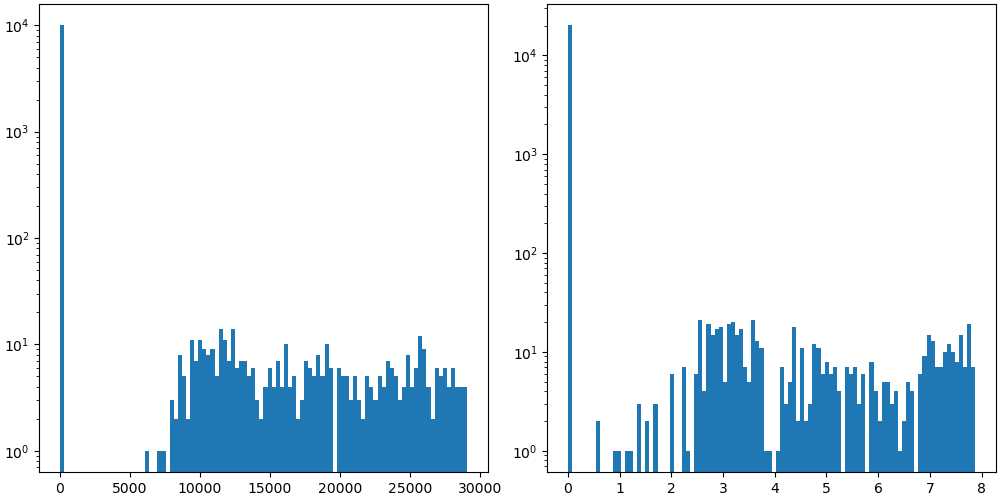

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
ax[0].hist(spks[:, iroi], bins=100, density=False)
ax[1].hist(spkmap[iroi].flatten(), bins=100, density=False)
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

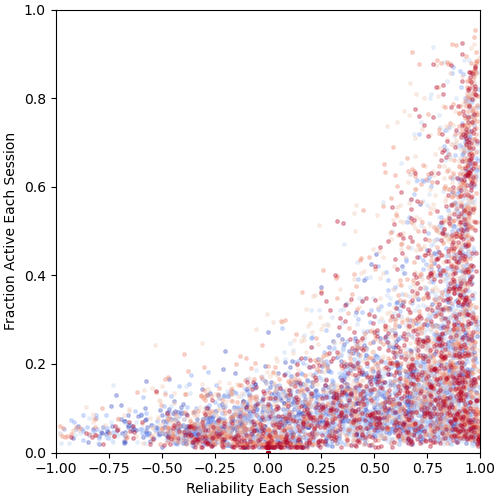

In [12]:
fraction_active_method = "rms"
fraction_active_type = "participation"
envoption = "second"
fraction_active_name = cell_loader._fraction_active_name(fraction_active_method, fraction_active_type)
fraction_active_data = cell_loader.fraction_active[envoption][fraction_active_name].T

min_percentile = 0
max_percentile = 100
red_cells = False
reliability_type = "all_trials"
idxs = cell_loader._gather_idxs(envoption, min_percentile, max_percentile, red_cells, reliability_type)

colors = plt.cm.coolwarm(np.linspace(0, 1, fraction_active_data.shape[1]))
colors = colors[:, :3]

reliability_data = np.stack(cell_loader.extras[envoption]["relloo"], axis=1)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
for i in range(fraction_active_data.shape[1]):
    ax.plot(
        reliability_data[idxs, i].T,
        fraction_active_data[idxs, i].T,
        color=colors[i],
        marker=".",
        markersize=5,
        alpha=0.3,
        linestyle="none",
    )

ax.set_xlabel("Reliability Each Session")
ax.set_ylabel("Fraction Active Each Session")
ax.set_xlim(-1.0, 1.0)  # Relloo, so it's an average correlation coefficient
ax.set_ylim(0, 1.0)  # Fractional measures so always between 0 and 1

plt.show()

In [38]:
from scipy.stats import binned_statistic_2d
from syd import Viewer
from vrAnalysis.metrics import KernelDensityEstimator

class FieldViewer(Viewer):
    def __init__(self, session_data):
        self.session_data = session_data
        self.add_integer("source_session", value=0, min_value=0, max_value=self.session_data.shape[0]-1)
        self.add_integer("target_session", value=1, min_value=0, max_value=self.session_data.shape[0]-1)
        self.add_integer("n_bins", value=20, min_value=5, max_value=50)
        self.add_boolean("do_scatter", value=True)
        self.add_float("quiver_scale", value=3.0, min_value=0.1, max_value=3.0, step=0.1)
        self.add_float_range("reliability_range", value=(-1.0, 1.0), min_value=-1.0, max_value=1.0, step=0.01)
        self.add_float_range("fraction_active_range", value=(0, 1.0), min_value=0, max_value=1.0, step=0.01)
        self.add_boolean("quiver_plot", value=False)

    def compute_velocity_field(self, data, next_data, n_bins=20):
        """
        data, next_data: arrays of shape (n_points, 2) containing current and next positions
        returns: velocity vectors and bin centers
        """
        # Compute velocities
        velocities = next_data - data
        
        # Compute mean velocity in each bin
        vx = binned_statistic_2d(data[:, 0], data[:, 1], velocities[:, 0], 
                                bins=n_bins, statistic='mean')[0]
        vy = binned_statistic_2d(data[:, 0], data[:, 1], velocities[:, 1], 
                                bins=n_bins, statistic='mean')[0]
        
        # Get bin centers
        x_bins = np.linspace(data[:, 0].min(), data[:, 0].max(), n_bins+1)
        y_bins = np.linspace(data[:, 1].min(), data[:, 1].max(), n_bins+1)
        x_centers = (x_bins[:-1] + x_bins[1:]) / 2
        y_centers = (y_bins[:-1] + y_bins[1:]) / 2
        
        return vx, vy, x_centers, y_centers
    
    def plot(self, state):
        if state["quiver_plot"]:
            return self.plot_field(state)
        
        else:
            return self.plot_distribution(state)
        
    def plot_field(self, state):
        source_session = state["source_session"]
        target_session = state["target_session"]
        n_bins = state["n_bins"]
        do_scatter = state["do_scatter"]
        quiver_scale = state["quiver_scale"]

        data = self.session_data[source_session]
        next_data = self.session_data[target_session]

        vx, vy, x, y = self.compute_velocity_field(data, next_data, n_bins)
        vx = vx * quiver_scale
        vy = vy * quiver_scale
        X, Y = np.meshgrid(x, y)
        
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.quiver(X, Y, vx.T, vy.T, scale=20, zorder=10)
        if do_scatter:
            ax.scatter(data[:, 0], data[:, 1], alpha=0.2, zorder=0, color="green", s=20, marker="o", edgecolor="none")
        ax.set_xlim(-1.0, 1.0)
        ax.set_ylim(0.0, 1.0)
        ax.set_xlabel("Reliability Values")
        ax.set_ylabel("Fraction Active Values")
        ax.set_title(f"Session: {source_session} -> {target_session}")
        return fig
    
    def plot_distribution(self, state):
        source_session = state["source_session"]
        target_session = state["target_session"]
        reliability_range = state["reliability_range"]
        fraction_active_range = state["fraction_active_range"]
        n_bins = state["n_bins"]

        data = self.session_data[source_session]
        
        idx_reliable = (data[:, 0] >= reliability_range[0]) & (data[:, 0] <= reliability_range[1])
        idx_active = (data[:, 1] >= fraction_active_range[0]) & (data[:, 1] <= fraction_active_range[1])
        idx = idx_reliable & idx_active

        next_data = self.session_data[target_session][idx]

        kde = KernelDensityEstimator(next_data[:, 0], next_data[:, 1], xrange=(-1.0, 1.0), yrange=(0, 1.0), nbins=n_bins).fit()
        plot_data = kde.plot_data
        extent = kde.extent

        fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained", sharex=True, sharey=True)
        ax[0].scatter(data[:, 0], data[:, 1], alpha=0.2, zorder=0, color="black", s=20, marker=".", edgecolor="none")
        ax[0].scatter(data[idx, 0], data[idx, 1], alpha=0.2, zorder=0, color="red", s=20, marker=".", edgecolor="none")
        ax[0].set_xlim(-1.0, 1.0)
        ax[0].set_ylim(0, 1.0)

        ax[1].imshow(np.flipud(plot_data), extent=extent, origin="lower", cmap="viridis")
        ax[1].set_xlim(extent[0], extent[1])
        ax[1].set_ylim(extent[2], extent[3])
        ax[1].set_xlabel("Reliability")
        ax[1].set_ylabel("Fraction Active")
        ax[1].set_title(f"Session: {source_session} -> {target_session}")
        
        return fig
    
fraction_active_method = "rms"
fraction_active_type = "participation"
envoption = "second"
fraction_active_name = cell_loader._fraction_active_name(fraction_active_method, fraction_active_type)
fraction_active_data = cell_loader.fraction_active[envoption][fraction_active_name].T
reliability_data = np.stack(cell_loader.extras[envoption]["relloo"], axis=1)
session_data = np.stack((reliability_data.T, fraction_active_data.T), axis=2)
field_viewer = FieldViewer(session_data).deploy()

No such comm: 53fd7c3354db45edaa714539ebd05389


No such comm: 468bebe4f5564a01ae99695708b2b971


No such comm: e71223fe9ef4478db91832b555b2a2c7


No such comm: b621d8433a4f4721b88729323782f0eb


No such comm: ac21ca0cf4b74b45bab555362b416b5c


No such comm: aa85d952a343491faab9dd5c3bc51e60


No such comm: 9ee16b7bff2c4cb487a9fb9fc4500ee7


No such comm: c1489455817b41938be355d32a4b37d3


No such comm: e97e419ebd6d4c9b87d9ed96df8bbcb1


No such comm: f36eba658e404fdb8d2cdf882c7bdc68


No such comm: e33399dae7084053897b5c67f0ffb737


No such comm: 5aaa8ade01ae46ffa684b02b71a62fc0


No such comm: 95a2854e0a1e43cd91c8f1c12adb4083


No such comm: 3ea7d9a3c9304ca39c27733e9e733668


No such comm: 3e5372f5d2274538ac17c3276ba94394


No such comm: 511e71e745f5446c8024f20f42b2db99


No such comm: 696696143af1459f85117cb579968075


No such comm: 48105525c366405997546bb64b592939


No such comm: 290e05f7ba3b4c87913f8c8478d1e7ac


No such comm: b849869fc9ef435db80d98ecfc2a9711


No such comm: 9dd3727b973c4041bd6e72f23bf35541


No such comm: 75c4c44536cf445f84e9f7667e34dce7


No such comm: 5ce6e1a5875544949353d481caca53f7


No such comm: fa3fbce554d84b9ea00d16401aa7da9b


No such comm: 4667b5ff50da4568b49e8c34baaadf01


No such comm: a13dc118fb3f44fc8861ab855ca71779


No such comm: 9c87f80ed20d4bc8a76833351cf56d80


No such comm: 8b74f41a757f41ed95e492911ac801a2


No such comm: d51abec4d44d43c09be59cb746512009
No such comm: d51abec4d44d43c09be59cb746512009
No such comm: d51abec4d44d43c09be59cb746512009
No such comm: d51abec4d44d43c09be59cb746512009


No such comm: 47261a069fc644c79588dde4a7e9ee9b


No such comm: e71c78dba9bd4c2abf6c33744fa09c9a


No such comm: dc7e8490ffc14f3b8792693636de295c


No such comm: 1f2661d415e943d394b63695522e4a73
No such comm: 1f2661d415e943d394b63695522e4a73
No such comm: 1f2661d415e943d394b63695522e4a73
No such comm: 1f2661d415e943d394b63695522e4a73
No such comm: 1f2661d415e943d394b63695522e4a73


No such comm: 4739c32883b3494a91b71305b3bec01d


No such comm: 6b687ffd16ac439f9829620c4a7ecd49
No such comm: 6b687ffd16ac439f9829620c4a7ecd49
No such comm: 6b687ffd16ac439f9829620c4a7ecd49
No such comm: 6b687ffd16ac439f9829620c4a7ecd49
No such comm: 6b687ffd16ac439f9829620c4a7ecd49
No such comm: 6b687ffd16ac439f9829620c4a7ecd49
